In [1]:
!apt-get update
!apt-get install -y xvfb python3-opengl ffmpeg
!pip install gymnasium[mujoco] imageio imageio-ffmpeg
!pip install tensorflow
!pip install jax jaxlib
!pip install pyvirtualdisplay

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,659 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [77.5 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,244 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,910 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchp

In [2]:
import os
from pyvirtualdisplay import Display

# Make sure any existing Xvfb processes are terminated
!pkill Xvfb || true

# Start virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

import gymnasium as gym
import imageio
import imageio.v3 as iio
import numpy as np
import tensorflow as tf
import collections
import time

In [3]:
# Create the Ant-v4 environment
print("Creating environments...")
env = gym.make("Ant-v5", render_mode="rgb_array")
eval_env = gym.make("Ant-v5", render_mode="rgb_array")
print("Environments created successfully!")


Creating environments...
Environments created successfully!


In [4]:
def record_video(agent, env, filename="training_video.mp4", num_frames=1000):
    frames = []
    observation, info = env.reset()
    for i in range(num_frames):
        # Render the environment and append the frame to the list
        frame = env.render()
        frames.append(frame)

        # Use the agent to take actions
        state = np.array(observation, dtype=np.float32)
        action = agent.select_action(state)
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            observation, info = env.reset()

    # Save frames as a video
    iio.imwrite(filename, frames, fps=30, codec='h264')
    print(f"Video saved as {filename}")


In [5]:
import tensorflow as tf
import numpy as np
import collections

class CriticNetwork(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(128, activation='relu')
        self.q_out = tf.keras.layers.Dense(1)

    def call(self, state_action):
        x = self.fc1(state_action)
        x = self.fc2(x)
        return self.q_out(x)

class ActorNetwork(tf.keras.Model):
    def __init__(self, action_dim, act_limit=1.0):
        super().__init__()
        self.act_limit = act_limit
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(128, activation='relu')
        self.mean = tf.keras.layers.Dense(action_dim)
        self.log_std = tf.keras.layers.Dense(action_dim)

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        mean = self.mean(x)
        log_std = tf.clip_by_value(self.log_std(x), -20, 2)  # limit for numerical stability
        return mean, log_std

    def sample(self, state):
        mean, log_std = self(state)
        std = tf.exp(log_std)
        noise = tf.random.normal(shape=mean.shape)
        action = mean + noise * std
        action_tanh = tf.tanh(action)
        scaled_action = self.act_limit * action_tanh

        # Log probability for SAC objective
        log_prob = -0.5 * ((noise ** 2) + 2 * log_std + np.log(2 * np.pi))
        log_prob = tf.reduce_sum(log_prob, axis=-1)
        log_prob -= tf.reduce_sum(tf.math.log(1 - action_tanh ** 2 + 1e-6), axis=1)
        # return action_tanh, log_prob
        return scaled_action, log_prob

In [6]:
class SACAgent:
    def __init__(self, obs_dim, act_dim, act_limit=1.0, gamma=0.99, tau=0.005, alpha=0.2):
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha
        self.act_limit = act_limit

        # ENTROPY SCALING FIX
        self.target_entropy = -act_dim  # Or use a custom value
        self.log_alpha = tf.Variable(0.0, dtype=tf.float32, trainable=True)
        self.alpha_opt = tf.keras.optimizers.Adam(learning_rate=3e-4)

        # Networks
        self.actor = ActorNetwork(act_dim, act_limit=act_limit)
        self.q1 = CriticNetwork()
        self.q2 = CriticNetwork()
        self.q1_target = CriticNetwork()
        self.q2_target = CriticNetwork()

        # # Sync target networks
        self.q1_target.set_weights(self.q1.get_weights())
        self.q2_target.set_weights(self.q2.get_weights())

        # Optimizers
        self.actor_opt = tf.keras.optimizers.Adam(3e-4)
        self.q1_opt = tf.keras.optimizers.Adam(3e-4)
        self.q2_opt = tf.keras.optimizers.Adam(3e-4)

        self.replay_buffer = collections.deque(maxlen=10000)
        self.batch_size = 256

    def select_action(self, obs, deterministic=False):
        obs = tf.convert_to_tensor([obs], dtype=tf.float32)
        mean, log_std = self.actor(obs)
        if deterministic:
            action = tf.tanh(mean)
        else:
            std = tf.exp(log_std)
            noise = tf.random.normal(shape=mean.shape)
            action = tf.tanh(mean + noise * std)
        # return action[0].numpy()
        return self.act_limit * action[0].numpy()

    def store(self, obs, act, rew, next_obs, done):
        self.replay_buffer.append((obs, act, rew, next_obs, float(done)))

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample batch
        idx = np.random.choice(len(self.replay_buffer), size=self.batch_size)
        batch = [self.replay_buffer[i] for i in idx]
        obs, act, rew, next_obs, done = map(np.array, zip(*batch))

        obs = tf.convert_to_tensor(obs, dtype=tf.float32)
        act = tf.convert_to_tensor(act, dtype=tf.float32)
        rew = tf.convert_to_tensor(rew, dtype=tf.float32)
        next_obs = tf.convert_to_tensor(next_obs, dtype=tf.float32)
        done = tf.convert_to_tensor(done, dtype=tf.float32)

        # -------------------- Update Q Networks --------------------
        with tf.GradientTape(persistent=True) as tape:
            next_action, next_logp = self.actor.sample(next_obs)
            # next_action = tf.clip_by_value(next_action, -self.act_limit, self.act_limit)
            sa_next = tf.concat([next_obs, next_action], axis=-1)

            target_q1 = self.q1_target(sa_next)
            target_q2 = self.q2_target(sa_next)
            # ENTROPY SCALING FIX
            # target_q = tf.minimum(target_q1, target_q2) - self.alpha * next_logp[:, None]
            alpha = tf.exp(self.log_alpha)
            target_q = tf.minimum(target_q1, target_q2) - alpha * next_logp[:, None]

            target = rew[:, None] + self.gamma * (1 - done[:, None]) * target_q

            sa = tf.concat([obs, act], axis=-1)
            q1_loss = tf.reduce_mean((self.q1(sa) - target) ** 2)
            q2_loss = tf.reduce_mean((self.q2(sa) - target) ** 2)

        self.q1_opt.apply_gradients(zip(tape.gradient(q1_loss, self.q1.trainable_variables), self.q1.trainable_variables))
        self.q2_opt.apply_gradients(zip(tape.gradient(q2_loss, self.q2.trainable_variables), self.q2.trainable_variables))
        del tape

        # -------------------- Update Policy --------------------
        with tf.GradientTape() as tape:
            new_action, logp = self.actor.sample(obs)
            sa_new = tf.concat([obs, new_action], axis=-1)
            q1_val = self.q1(sa_new)
            q2_val = self.q2(sa_new)
            q_min = tf.minimum(q1_val, q2_val)

            # ENTROPY SCALING FIX
            # actor_loss = tf.reduce_mean(self.alpha * logp - q_min)
            alpha = tf.exp(self.log_alpha)
            actor_loss = tf.reduce_mean(alpha * logp - q_min)

        self.actor_opt.apply_gradients(zip(tape.gradient(actor_loss, self.actor.trainable_variables), self.actor.trainable_variables))

        # ---------- Entropy temperature (alpha) update ----------
        with tf.GradientTape() as tape:
          alpha_loss = -tf.reduce_mean(self.log_alpha * tf.stop_gradient(logp + self.target_entropy))


        self.alpha_opt.apply_gradients([(tape.gradient(alpha_loss, [self.log_alpha])[0], self.log_alpha)])

        # -------------------- Soft Target Updates --------------------
        for param, target_param in zip(self.q1.trainable_variables, self.q1_target.trainable_variables):
            target_param.assign(self.tau * param + (1 - self.tau) * target_param)

        for param, target_param in zip(self.q2.trainable_variables, self.q2_target.trainable_variables):
            target_param.assign(self.tau * param + (1 - self.tau) * target_param)

In [7]:
def record_random_video(env, filename="random_action_video.mp4", num_frames=100):
    frames = []
    observation, info = env.reset()
    for i in range(num_frames):
        frame = env.render()
        frames.append(frame)
        action = env.action_space.sample()  # Random action
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            observation, info = env.reset()

    # Use updated imageio.v3 API
    iio.imwrite(filename, frames, fps=30, codec='h264')
    print(f"Random action video saved as {filename}")

In [8]:
# Wait a moment for display to initialize
print("Waiting for display to initialize...")
time.sleep(5)

# # Record a quick random action video to verify the setup
# print("Recording a test video with random actions...")
# try:
#     record_random_video(eval_env)
#     print("Test video recorded successfully!")
# except Exception as e:
#     print(f"Error recording test video: {e}")

observation_shape = env.observation_space.shape[0]
action_shape = env.action_space.shape[0]
act_limit = env.action_space.high[0]  # assumes symmetric action space

agent = SACAgent(observation_shape, action_shape, act_limit=act_limit)

# agent = SACAgent(observation_shape, action_shape)
print("Starting training with custom SAC agent...")
# Reduced number of iterations for faster testing, increase for better results
# agent.train(num_iterations=8000)

obs = env.reset()[0]  # unpack observation if using gymnasium
episode_return, episode_length = 0, 0
episode_count = 0
total_steps = 25000
initial_random_steps = 1000
update_after = 1000
update_freq = 10
updates_per_step = 10
video_interval = 2500  # Record video every 25000 steps

episode_returns = {}

for step in range(1, total_steps + 1):
    # Pure exploration at first
    if step <= initial_random_steps:
        action = env.action_space.sample()
    else:
        # Sample action from policy
        action = agent.select_action(obs)

    # Step the environment
    next_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    # Store in replay buffer
    agent.store(obs, action, reward, next_obs, done)

    # Update agent
    # agent.update()

    with tf.device('/GPU:0'):
      # Update agent - but only after enough data and not every step
      if step > update_after and step % update_freq == 0:
        for _ in range(updates_per_step):
            agent.update()

    obs = next_obs
    episode_return += reward
    episode_length += 1


    # Reset if episode ends
    if done:
        print(f"Step {step}: Return={episode_return:.2f}, Length={episode_length}")
        obs = env.reset()[0]
        episode_returns[episode_count] = episode_return
        episode_count += 1
        episode_return, episode_length = 0, 0

    # Record video periodically
    if step % video_interval == 0:
        video_filename = f"full_sac_video_step_{step}.mp4"
        record_video(agent, eval_env, filename=video_filename)
        print(f"Recorded evaluation video at step {step}")

# Final video after training
record_video(agent, eval_env, filename="final_full_sac_ant.mp4")
print("Final video recorded after training.")

# Clean up the display when done
display.stop()

Waiting for display to initialize...
Starting training with custom SAC agent...
Step 47: Return=-19.13, Length=47
Step 68: Return=-10.77, Length=21
Step 369: Return=-94.90, Length=301
Step 415: Return=6.33, Length=46
Step 487: Return=-27.55, Length=72
Step 618: Return=-33.57, Length=131
Step 697: Return=-27.50, Length=79
Step 1018: Return=-127.02, Length=321
Step 1058: Return=-3.90, Length=40
Step 1166: Return=-78.82, Length=108
Step 1228: Return=-65.34, Length=62
Step 1382: Return=-19.23, Length=154
Step 1500: Return=-36.37, Length=118
Step 1530: Return=-14.13, Length=30
Step 1565: Return=-5.99, Length=35
Step 1605: Return=3.80, Length=40
Step 1659: Return=-69.03, Length=54
Step 1705: Return=-11.66, Length=46
Video saved as full_sac_video_step_2500.mp4
Recorded evaluation video at step 2500
Step 2705: Return=-383.04, Length=1000
Step 2805: Return=-24.43, Length=100
Step 2872: Return=-24.47, Length=67
Step 2917: Return=-48.23, Length=45
Step 2975: Return=-7.33, Length=58
Step 3058: Ret

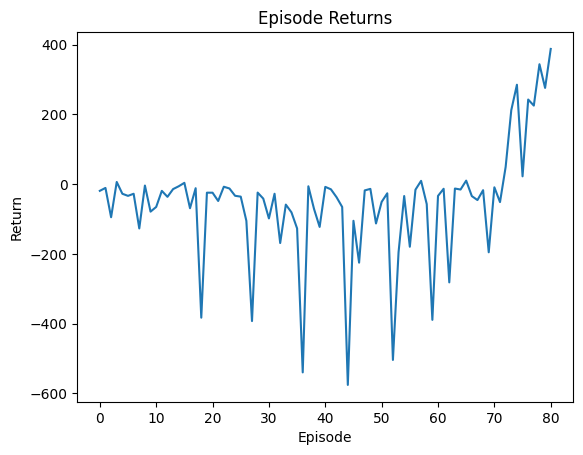

In [9]:
import matplotlib.pyplot as plt

episodes = list(episode_returns.keys())
returns = list(episode_returns.values())

plt.plot(episodes, returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Episode Returns")
plt.show()